# **<center>Brain Tumour Classification</center>**

# 1. Importing the libraries <a class="anchor" id="h2"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

import torchvision
from torchvision import datasets, models, transforms

from timeit import default_timer as timer

# 2. Data Source and Description <a class="anchor" id="h2"></a>

## 2.1 Data Source: <a class="anchor" id="h2_1"></a>

This Dataset has been collected from kaggle https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

## 2.2 Data Description: <a class="anchor" id="h2_2"></a>

This dataset is a combination of the following three datasets :

figshare[https://figshare.com/articles/dataset/brain_tumor_dataset/1512427]

SARTAJ dataset[https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri]

Br35H[https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection?select=no]

This dataset contains 7023 images of human brain MRI images which are classified into 4 classes: glioma - meningioma - no tumor and pituitary.

no tumor class images were taken from the Br35H dataset.

## 2.3 Loading the data:

In [2]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

PATH = "/kaggle/input/brain-tumor-mri-dataset"

master_dict = {}

for dir_l1 in os.listdir(PATH):
    path_l1 = os.path.join(PATH, dir_l1)
    for dir_l2 in os.listdir(path_l1):
        if dir_l2 not in master_dict.keys():
            master_dict[dir_l2] = []
        path_l2 = os.path.join(path_l1, dir_l2)
        for file in os.listdir(path_l2):
            path_l3 = os.path.join(path_l2, file)
            master_dict[dir_l2].append(path_l3)
            

In [3]:
#Randomly shuffling the data:

import random

for key in master_dict.keys():
    random.shuffle(master_dict[key])

In [4]:
#Taking a portion of the entire data:

amount = 1.0 #100% of the data
for key in master_dict.keys():
    master_dict[key] = master_dict[key][:round(len(master_dict[key])*amount)]

In [5]:
#Splitting the data into train and test set:

test_split = 0.1 #Using 90% of the data for training and 10% for testing

train_dict = {}
valid_dict = {}

for key in master_dict.keys():
    train_dict[key] = master_dict[key][:round(len(master_dict[key])*(1-test_split))]
    valid_dict[key] = master_dict[key][round(len(master_dict[key])*(1-test_split)):]

In [6]:
def visualize(data_dict):    
    idx = np.random.randint(0,min(list([len(l) for l in data_dict.values()])))

    plt.figure(figsize=(20,6))
    plt.subplot(161)
    plt.imshow(cv2.imread(train_dict['glioma'][idx]).astype(int))
    plt.title('Glioma')
    plt.subplot(162)
    plt.imshow(cv2.imread(train_dict['meningioma'][idx]).astype(int))
    plt.title('Menignoma')
    plt.subplot(163)
    plt.imshow(cv2.imread(train_dict['notumor'][idx]).astype(int))
    plt.title('No Tumor')
    plt.subplot(164)
    plt.imshow(cv2.imread(train_dict['pituitary'][idx]).astype(int))
    plt.title('Pituitary')

    plt.show()

In [7]:
train_dict.keys()

dict_keys(['pituitary', 'notumor', 'meningioma', 'glioma'])

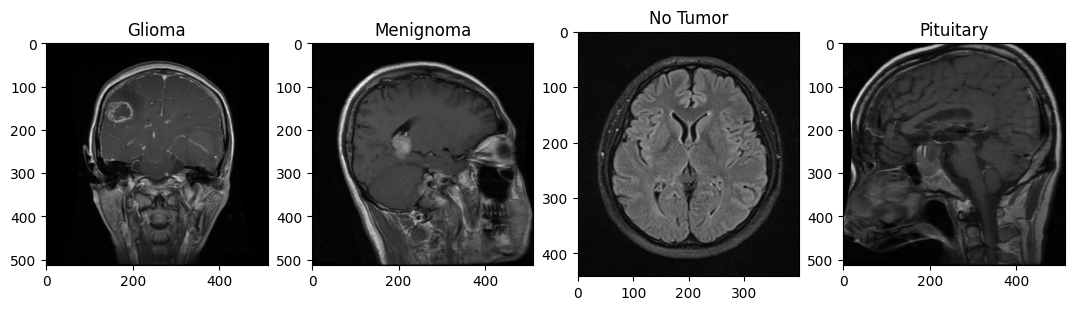

In [8]:
# training data
visualize(train_dict)

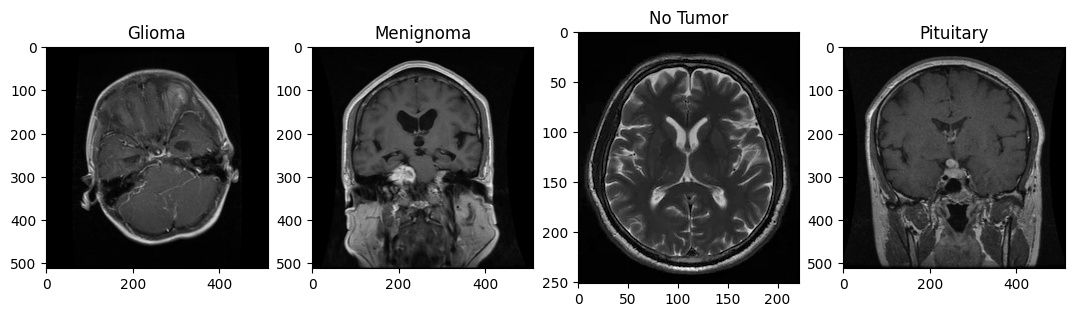

In [9]:
# validation data
visualize(valid_dict)

In [10]:
print('training data sizes : ', [len(l) for l in train_dict.values()])
print('validation data sizes : ', [len(l) for l in valid_dict.values()])

training data sizes :  [1581, 1800, 1480, 1459]
validation data sizes :  [176, 200, 165, 162]


In [11]:
## dataset class

class MRIData(Dataset):
    """Chess Piece Dataset class"""
    
    def __init__(self, data_dict, transform=None):
        """
        Args:
            data_dict (dict): dictionary with class as key and the corresponding paths to the data of that class 
        """
        self.data_dict = data_dict
        self.transform = transform
        
    def __len__(self):
        return sum([len(l) for l in self.data_dict.values()])
    
    def __getitem__(self,idx):
        counts = [len(l) for l in self.data_dict.values()]
        sum_counts = list(np.cumsum(counts))
        sum_counts = [0] + sum_counts + [np.inf]
        
        for c,v in enumerate(sum_counts):
            if idx < v:
                i = (idx - sum_counts[c-1]) - 1
                break
        #print(c,i,idx)
        label = list(self.data_dict.keys())[c-1]
        img = Image.open(self.data_dict[str(label)][i]).convert('RGB')
        if self.transform:
            img = self.transform(img)
            
        return img, classes.index(str(label))

As the number of data per class is not too much, so data augmentation plays a vital role in here.

In [12]:
#  data augmentation

data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomAdjustSharpness(sharpness_factor=1.5),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ColorJitter(),
                                     transforms.Resize((224,224))])

data_train = MRIData(train_dict,transform = data_transform)
data_valid = MRIData(valid_dict,transform = data_transform)

Total Number of training images :  6320
Total Number of validation images :  703


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


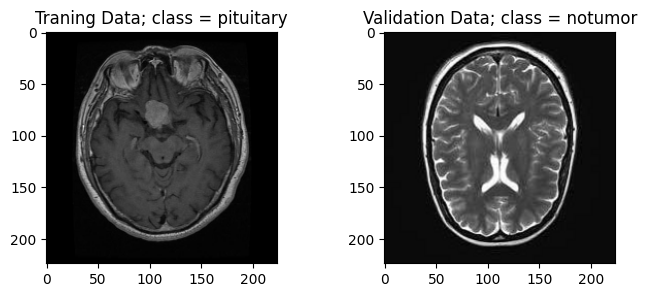

In [13]:
t_idx = np.random.randint(0,len(data_train))
v_idx = np.random.randint(0,len(data_valid))

print("Total Number of training images : ", len(data_train))
print("Total Number of validation images : ", len(data_valid))

t_img,t_label = data_train[t_idx]
v_img,v_label = data_valid[v_idx]

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.imshow(t_img.numpy().transpose(1,2,0))
plt.title(f'Traning Data; class = {classes[t_label]}')
plt.subplot(122)
plt.imshow(v_img.numpy().transpose(1,2,0))
plt.title(f'Validation Data; class = {classes[v_label]}')
plt.show()

In [14]:
# definning data loader

train_loader = DataLoader(data_train, batch_size=50, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=50, shuffle=True)

In [15]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched[0].size(),sample_batched[1])
    print(type(sample_batched[0]))
    break

0 torch.Size([50, 3, 224, 224]) tensor([2, 3, 1, 2, 1, 3, 2, 0, 3, 3, 1, 2, 0, 2, 0, 3, 1, 2, 3, 3, 2, 0, 0, 2,
        2, 0, 0, 2, 2, 0, 0, 3, 0, 2, 2, 3, 1, 0, 1, 1, 2, 0, 3, 2, 1, 2, 3, 1,
        1, 1])
<class 'torch.Tensor'>


In [16]:
# definnig the loss function

import torch.optim as optim
import torch.nn as nn

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

we are using the binary cross entropy loss here and as we are going to use the ResNet architechture the loss surface is going to be rough and messy. Lets see which optimizer gives the best result.

### **Model define**

In [17]:
#Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 324MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features)

4096
1000


In [19]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [20]:
n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("training on gpu...")
    vgg16.cuda()
else:
    print("no gpu found.")

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
print(vgg16)

training on gpu...
4
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, 

In [21]:
def base_model_build():
    #Load the pretrained model from pytorch
    vgg16 = models.vgg16(pretrained=True)

    # print out the model structure
    #print(vgg16)
    
    # Freeze training for all "features" layers
    for param in vgg16.features.parameters():
        param.requires_grad = False
        
    import torch.nn as nn

    n_inputs = vgg16.classifier[6].in_features

    # add last linear layer (n_inputs -> 5 flower classes)
    # new layers automatically have requires_grad = True
    last_layer = nn.Linear(n_inputs, len(classes))

    vgg16.classifier[6] = last_layer

    # if GPU is available, move the model to GPU
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        print("training on gpu...")
        vgg16.cuda()
    else:
        print("no gpu found.")

    # check to see that your last layer produces the expected number of outputs
    #print(vgg16.classifier[6].out_features)
    #print(vgg16)
    
    return vgg16


def loss_acc_visuaize(history,optim,path):
    plt.figure(figsize=(20,10))

    plt.suptitle(str(optim))

    plt.subplot(121)
    plt.plot(history['train_loss'],label='train_loss')
    plt.plot(history['valid_loss'],label='valid_loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(122)
    plt.plot(history['train_acc'],label='train_acc')
    plt.plot(history['valid_acc'],label='valid_acc')
    plt.legend()
    plt.title('Accuracy Curves')
    
    plt.savefig(str(path) + 'loss_acc.png')


# def grad_visualize(history,optim,path,ylimit=10):
#     # gadient norm distribution

#     import seaborn as sns

#     plt.figure(figsize=(20,10))

#     plt.suptitle(str(optim))

#     plt.subplot(131)
#     sns.kdeplot(weight_grads1, shade=True)
#     sns.kdeplot(bias_grads1, shade=True)
#     plt.legend(['weight','bias'])
#     plt.title('Linear layer 1')
#     #plt.gca().set_xlim(left=0)
#     plt.ylim(0,ylimit)

#     plt.subplot(132)
#     sns.kdeplot(weight_grads2, shade=True)
#     sns.kdeplot(bias_grads2, shade=True)
#     plt.legend(['weight','bias'])
#     plt.title('Linear layer 2')
#     #plt.gca().set_xlim(left=0)
#     plt.ylim(0,ylimit)

#     plt.subplot(133)
#     sns.kdeplot(weight_grads3, shade=True)
#     sns.kdeplot(bias_grads3, shade=True)
#     plt.legend(['weight','bias'])
#     plt.title('Linear layer 3')
#     #plt.gca().set_xlim(left=0)
#     plt.ylim(0,ylimit)
    
#     plt.savefig(str(path) + 'grad_norms.png')
    

def visual_predict(model,data=data_valid):
    c = np.random.randint(0,len(data))
    img, label = data[c]

    with torch.no_grad():
            model.eval()
            # Model outputs log probabilities
            out = model(img.view(1,3,224,224).cuda())
            out = torch.exp(out)
            print(out)

    plt.figure(figsize = (10,5))
    plt.subplot(121)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.title(str(classes[label]))
    plt.subplot(122)
    plt.barh(classes,out.cpu().numpy()[0])

    plt.show()
    

def class_accuracies(model,data_dict=valid_dict,classes=classes):
    accuracy_dict = {}
    with torch.no_grad():
        model.eval()
        for c in data_dict.keys():
            correct_count = 0
            total_count = len(data_dict[str(c)])
            gt = classes.index(str(c))
            for path in data_dict[str(c)]:
                #print(path)
                im = Image.open(path).convert('RGB')
                #im.show()
                im = transforms.ToTensor()(im)
                im = transforms.Resize((224,224))(im)
                out = model(im.view(1,3,224,224).cuda())
                #print(out)
                out = torch.exp(out)
                pred = list(out.cpu().numpy()[0])
                #print(pred)
                pred = pred.index(max(pred))
                #print(pred,gt)

                if gt == pred:
                    correct_count += 1
            print(f"Accuracy for class {str(c)} : ",correct_count/total_count)
            accuracy_dict[str(c)] = correct_count/total_count
    return accuracy_dict

## Training:

In [22]:
vgg16 = base_model_build()
opt = optim.Adagrad(vgg16.classifier.parameters(), lr=0.001)

model=vgg16
criterion=criterion
optimizer=opt
train_loader=train_loader
valid_loader=valid_loader
save_file_name='vgg16.pth'
max_epochs_stop=20
n_epochs=30
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 163.24 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 0.5569 	Validation Loss: 0.3957
		Training Accuracy: 78.16%	 Validation Accuracy: 84.78%
Epoch: 1	100.00% complete. 129.52 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.2719 	Validation Loss: 0.2271
		Training Accuracy: 89.65%	 Validation Accuracy: 90.75%
Epoch: 2	100.00% complete. 127.75 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.1996 	Validation Loss: 0.1744
		Training Accuracy: 92.36%	 Validation Accuracy: 93.60%
Epoch: 3	100.00% complete. 129.07 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.1582 	Validation Loss: 0.1452
		Training Accuracy: 94.38%	 Validation Accuracy: 94.74%
Epoch: 4	100.00% complete. 127.24 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.1301 	Validation Loss: 0.1401
		Training Accuracy: 95.27%	 Validation Accuracy: 94.45%
Epoch: 5	100.00% complete. 128.81 seconds elapsed in epoch.
Epoch: 5 	Training

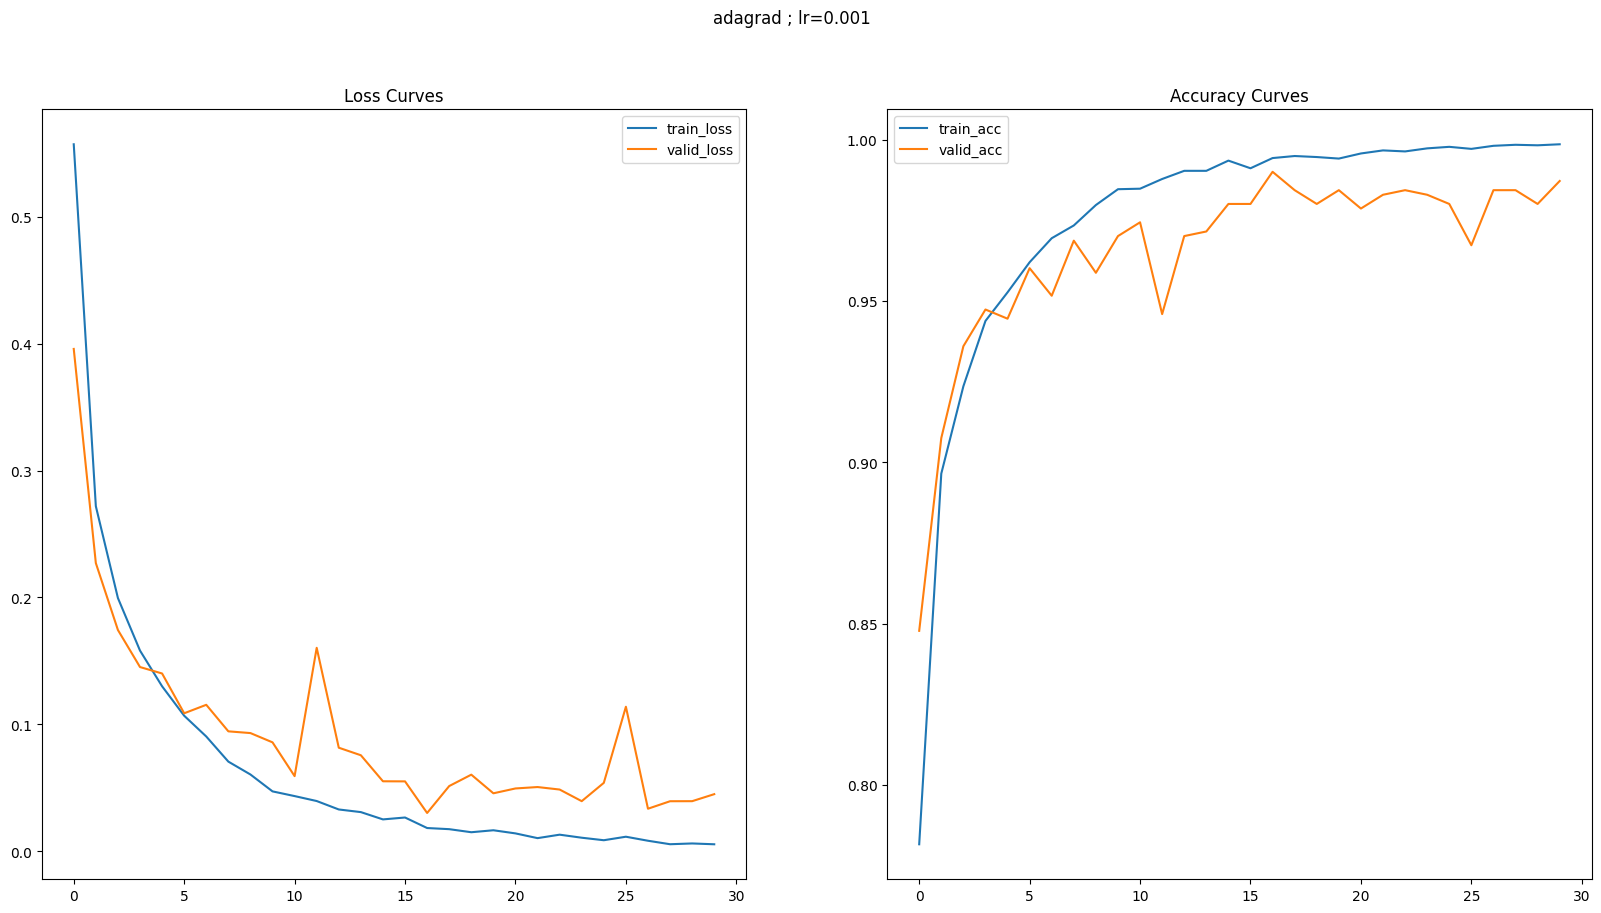

In [23]:
loss_acc_visuaize(history,optim="adagrad ; lr=0.001",path="../lr=0.001")

In [24]:
#grad_visualize(history,optim="adagrad ; lr=0.001",path="../lr=0.001")

In [25]:
model = base_model_build()
model.load_state_dict(torch.load(save_file_name))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training on gpu...


<All keys matched successfully>

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[9.5867e-04, 1.0711e-02, 1.6998e-03, 4.4117e+04]], device='cuda:0')


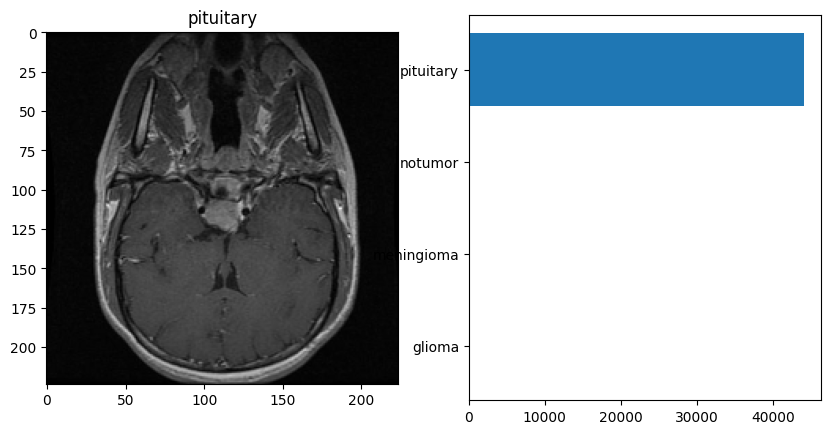

In [26]:
visual_predict(model)

In [27]:
class_accuracies(model)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy for class pituitary :  1.0
Accuracy for class notumor :  1.0
Accuracy for class meningioma :  0.9636363636363636
Accuracy for class glioma :  0.9691358024691358


{'pituitary': 1.0,
 'notumor': 1.0,
 'meningioma': 0.9636363636363636,
 'glioma': 0.9691358024691358}

In [28]:
valid_loss = 0.0
valid_acc = 0

with torch.no_grad():
    # Set to evaluation mode
    model.eval()

    # Validation loop
    for data, target in valid_loader:
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Forward pass
        output = model(data)

        # Validation loss
        loss = criterion(output, target)
        # Multiply average loss times the number of examples in batch
        valid_loss += loss.item() * data.size(0)

        # Calculate validation accuracy
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        accuracy = torch.mean(
            correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples
        valid_acc += accuracy.item() * data.size(0)

    # Calculate average losses
    valid_loss = valid_loss / len(valid_loader.dataset)

    # Calculate average accuracy
    valid_acc = valid_acc / len(valid_loader.dataset)
    
    print("Validation loss:", valid_loss)
    print("Validation accuracy:", valid_acc)

Validation loss: 0.048317561928940614
Validation accuracy: 0.9815078200520696
